In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.5 MB/s eta 0:00:00


In [ ]:
import time
import requests
import tarfile
from os import path
from math import floor
from collections import Counter
import gc

import networkx as nx
import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.utils import to_undirected, is_undirected
from torch_geometric.explain import Explainer, GNNExplainer

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
# downloading dataset
#   source             : https://developer.ibm.com/exchanges/data/all/airline/
#   column descriptions: https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/data-preview/index.html

url = 'https://dax-cdn.cdn.appdomain.cloud/dax-airline/1.0.1/airline_2m.tar.gz'
filename = url.split('/')[-1]
data_path = filename.replace('.tar.gz', '.csv')

if path.exists(data_path):
    print('Already downloaded, not doing anything')
else:
    print('Downloading dataset...'.capitalize())
    resp = requests.get(url)

    with open(filename, 'wb') as f:
        f.write(resp.content)

    print('Downloaded, extracting...')
    with tarfile.open(filename) as tar:
        tar.extractall()
    success = path.exists(data_path)
    print('Done' if success else 'Something went wrong')

Downloaded, extracting...
Done


In [ ]:
!ls

airline_2m.csv	airline_2m.tar.gz  sample_data


In [ ]:
df = pd.read_csv(data_path, encoding = "ISO-8859-1",
                 dtype={'Div1Airport': str, 'Div1TailNum': str, 'Div2Airport': str, 'Div2TailNum': str})

In [ ]:
print('column names:\n\t',end='')
for i, item in enumerate(list(df.columns)):
    print(item, end=' ')
    if i > 0 and i % 5 == 0:
        print('\n\t', end='')

column names:
	Year Quarter Month DayofMonth DayOfWeek FlightDate 
	Reporting_Airline DOT_ID_Reporting_Airline IATA_CODE_Reporting_Airline Tail_Number Flight_Number_Reporting_Airline 
	OriginAirportID OriginAirportSeqID OriginCityMarketID Origin OriginCityName 
	OriginState OriginStateFips OriginStateName OriginWac DestAirportID 
	DestAirportSeqID DestCityMarketID Dest DestCityName DestState 
	DestStateFips DestStateName DestWac CRSDepTime DepTime 
	DepDelay DepDelayMinutes DepDel15 DepartureDelayGroups DepTimeBlk 
	TaxiOut WheelsOff WheelsOn TaxiIn CRSArrTime 
	ArrTime ArrDelay ArrDelayMinutes ArrDel15 ArrivalDelayGroups 
	ArrTimeBlk Cancelled CancellationCode Diverted CRSElapsedTime 
	ActualElapsedTime AirTime Flights Distance DistanceGroup 
	CarrierDelay WeatherDelay NASDelay SecurityDelay LateAircraftDelay 
	FirstDepTime TotalAddGTime LongestAddGTime DivAirportLandings DivReachedDest 
	DivActualElapsedTime DivArrDelay DivDistance Div1Airport Div1AirportID 
	Div1AirportSeqID Div1Whe

In [ ]:
feature_cols = ['FlightDate', 'Reporting_Airline', 'Origin', 'Dest', 'CRSDepTime',
                'DepTime', 'Tail_Number', 'OriginState',
                'Flight_Number_Reporting_Airline', 'Distance']
target_col = ['ArrDel15'] # whether arrival was delayed by more than 15 mins

In [ ]:
df.groupby('Year').count()['Quarter']

,Quarter
Year,
1987,13504
1988,53333
1989,52028
1990,54709
1991,52006
1992,52360
1993,52438
1994,53325
1995,54653


In [ ]:
# get rid of rows with nan fields, select our rows
df_selected = df[feature_cols + target_col].dropna()

# free some RAM
# del df
# del shuffled_df
# gc.collect()

# make DepTime,ArrDel15 values ints (they look like ints)
df_selected['DepTime'] = df_selected['DepTime'].astype(int)
df_selected['ArrDel15'] = df_selected['ArrDel15'].astype(int)

# undersample to get 50-50 balance of delayed / not delayed flights
delayed = df_selected[df_selected['ArrDel15'] == 1]
not_delayed = df_selected[df_selected['ArrDel15'] == 0]
min_count = min(len(delayed), len(not_delayed))
if len(delayed) > min_count:
    delayed = delayed.sample(n=min_count, random_state=42)
else:
    not_delayed = not_delayed.sample(n=min_count, random_state=42)
df_selected = pd.concat([delayed, not_delayed]).sample(frac=1, random_state=42).reset_index(drop=True)

# keep max 10K rows
max_rows = 10_000
if len(df_selected) > max_rows:
    df_selected = df_selected.sample(n=max_rows)

# add FlightId column
df_selected['FlightId'] = pd.RangeIndex(len(df_selected.index))
df_selected.set_index('FlightId', drop=False, inplace=True)

# add a datetime column
flightDateStr = df_selected['FlightDate'].astype('str')
depTimeStr = df_selected['DepTime'].astype('int').astype('str').apply(lambda s: s.zfill(4)).apply(lambda s: f"00{s[2:]}" if s.startswith('24') else s)
df_selected['DepDatetime'] = pd.to_datetime(flightDateStr + ' ' + depTimeStr, format='%Y-%m-%d %H%M')

In [ ]:
df_selected

,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,DepTime,Tail_Number,OriginState,Flight_Number_Reporting_Airline,Distance,ArrDel15,FlightId,DepDatetime
FlightId,,,,,,,,,,,,,
0,2006-06-03,UA,DEN,BOI,1103,1126,N933UA,CO,775,649.0,1,0,2006-06-03 11:26:00
1,2003-01-02,AA,ATL,DFW,1300,1256,N2BPAA,GA,1662,732.0,0,1,2003-01-02 12:56:00
2,2004-02-05,DL,CVG,DFW,1230,1229,N314DA,KY,661,812.0,1,2,2004-02-05 12:29:00
3,2005-03-19,HP,PHX,OAK,2014,2015,N160AW,AZ,627,646.0,0,3,2005-03-19 20:15:00
4,2012-05-05,EV,EWR,AVL,1000,1009,N14177,NJ,4125,583.0,1,4,2012-05-05 10:09:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1998-09-23,WN,TUL,HOU,1015,1015,N674,OK,705,453.0,0,9995,1998-09-23 10:15:00
9996,2011-11-22,CO,BOS,EWR,1300,1259,N14604,MA,1593,200.0,0,9996,2011-11-22 12:59:00
9997,2018-09-07,WN,MDW,DCA,1515,1513,N466WN,IL,283,601.0,1,9997,2018-09-07 15:13:00


In [ ]:
graph = nx.Graph()

# add a node for each flight, then connect them with edges based on similarity:
#    same origin and close departure time, same origin/destination, ...

for i, row in df_selected.iterrows():
    kwargs = {key:row[key] for key in feature_cols}
    graph.add_node(row['FlightId'], **kwargs) # attribs

seconds_threshold = 60*60*6 # six hours
for _, group in df_selected.groupby(['Origin', ]):
    group.sort_values(by='DepDatetime', inplace=True)
    for i in range(len(group)):
        for j in range(i+1, len(group)):
            row_a, row_b = group.iloc[i], group.iloc[j]
            time_difference = row_a['DepDatetime'] - row_b['DepDatetime']
            if abs(time_difference.total_seconds()) <= seconds_threshold:
                graph.add_edge(int(row_a['FlightId']), int(row_b['FlightId']))
            else:
                break

for _, group in df_selected.groupby(['Origin', 'Dest']):
    for i in range(len(group)):
        for j in range(i+1, len(group)):
            row_a, row_b = group.iloc[i], group.iloc[j]
            graph.add_edge(int(row_a['FlightId']), int(row_b['FlightId']))

for _, group in df_selected.groupby(['Tail_Number', 'FlightDate']):
    for i in range(len(group)):
        for j in range(i+1, len(group)):
            row_a, row_b = group.iloc[i], group.iloc[j]
            graph.add_edge(int(row_a['FlightId']), int(row_b['FlightId']))

for _, group in df_selected.groupby(['Flight_Number_Reporting_Airline', 'FlightDate']):
    for i in range(len(group)):
        for j in range(i+1, len(group)):
            row_a, row_b = group.iloc[i], group.iloc[j]
            graph.add_edge(int(row_a['FlightId']), int(row_b['FlightId']))

In [ ]:
# making x and y...

node_dict = dict(graph.nodes(data=True))

flightDates, reportingAirlines, origins, dests, crsDepTimes, depTimes, tailNumbers, originStates, flightNumbers, distances = [], [], [], [], [], [], [], [], [], []
sinks = flightDates, reportingAirlines, origins, dests, crsDepTimes, depTimes, tailNumbers, originStates, flightNumbers, distances
for flightId, attribs in node_dict.items():
    taps = list(attribs.values())
    for tap, sink in zip(taps, sinks):
        sink.append(tap)

flightDates = LabelEncoder().fit_transform(flightDates)
reportingAirlines = LabelEncoder().fit_transform(reportingAirlines)
origins = LabelEncoder().fit_transform(origins)
dests = LabelEncoder().fit_transform(dests)
tailNumbers = LabelEncoder().fit_transform(tailNumbers)
originStates = LabelEncoder().fit_transform(originStates)

X = StandardScaler().fit_transform(
    np.column_stack((
        flightDates, reportingAirlines, origins, dests, crsDepTimes, depTimes,
        tailNumbers, originStates, flightNumbers, distances))
)
y = np.array(df_selected[target_col]).flatten()

# more edges: connect flights with similar features (cosine similarity)
def add_knn_edges(graph, X, k=5):
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(X)
    distances, indices = nbrs.kneighbors(X)
    for i, neighbors in enumerate(indices):
        for j in neighbors[1:]:
            graph.add_edge(int(df_selected.iloc[i]['FlightId']), int(df_selected.iloc[j]['FlightId']))

add_knn_edges(graph, X)
print(f"edge count: {graph.number_of_edges()}")

# train and test masks...
train_ratio = 0.80
total_count = len(X)
train_count = floor(train_ratio * total_count)
test_count = total_count - train_count
train_mask = np.concatenate([np.ones(train_count, dtype=bool), np.zeros(test_count, dtype=bool)])
test_mask = np.concatenate([np.zeros(train_count, dtype=bool), np.ones(test_count, dtype=bool)])

# making edge_index...
edge_list = list(graph.edges)
u_list = list(map(lambda edge: edge[0], edge_list))
v_list = list(map(lambda edge: edge[1], edge_list))
edge_index = np.array((u_list, v_list))

edge count: 55851


In [ ]:
delayRatio = y.sum()/len(y)
print(f"Class distribution: {delayRatio*100}% delayed, {(1-delayRatio)*100}% not delayed")

Class distribution: 49.32% delayed, 50.67999999999999% not delayed


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        self.conv1 = SAGEConv(num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = nn.Linear(hidden_channels, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.classifier(x)
        x = F.log_softmax(x, dim=1)
        return x

device = "cpu"

data = Data(x=torch.from_numpy(X).float(),
            edge_index=to_undirected(torch.from_numpy(edge_index).long()),
            y=torch.from_numpy(y),
            train_mask=torch.from_numpy(train_mask),
            test_mask=torch.from_numpy(test_mask))
model = GCN(num_features=data.num_features, hidden_channels=16)

model = model.to(device)
data = data.to(device)

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.NLLLoss()

def train():
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test():
      out = model(data.x, data.edge_index)
      # Use the class with highest probability.
      pred = out.argmax(dim=1)
      print(classification_report(data.y[data.test_mask], pred[data.test_mask],
                                  target_names=["Not Delayed", "Delayed"]))

def train_accuracy():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[data.train_mask] == data.y[data.train_mask]
    return correct.sum().item() / data.train_mask.sum().item()

losses = []

model.train()
for epoch in range(500):
    loss = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

model.eval()
test_acc = test()
train_acc = train_accuracy()
print(f'***** Evaluating the test dataset ***** ')
print(f'Train Accuracy: {train_acc:.4f}')

Epoch: 000, Loss: 0.7266
Epoch: 100, Loss: 0.4093
Epoch: 200, Loss: 0.3676
Epoch: 300, Loss: 0.3425
Epoch: 400, Loss: 0.3327
              precision    recall  f1-score   support

 Not Delayed       0.80      0.86      0.83      1018
     Delayed       0.84      0.77      0.81       982

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000

***** Evaluating the test dataset ***** 
Train Accuracy: 0.8675


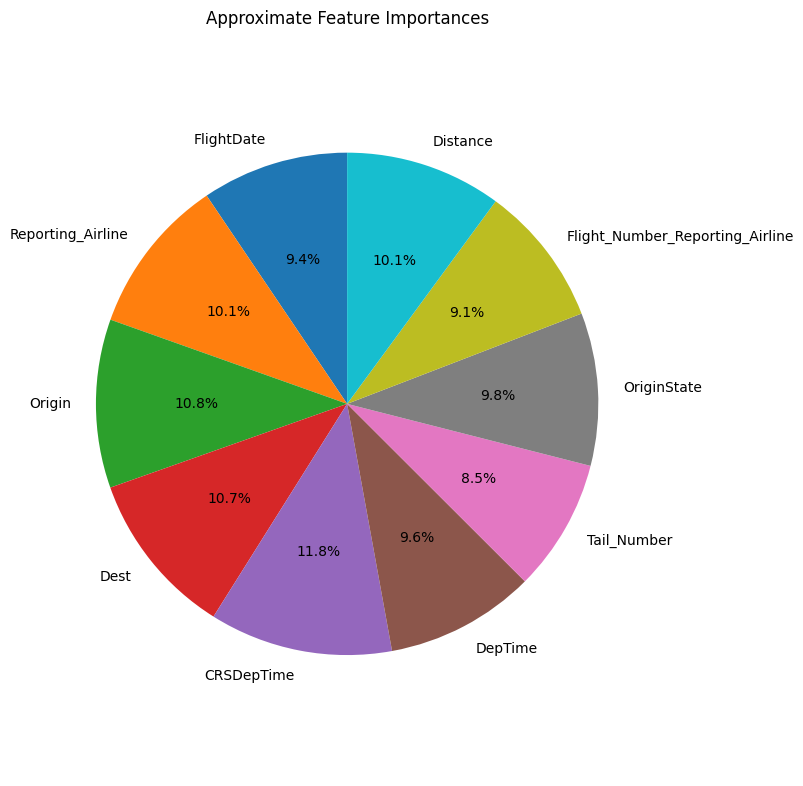

In [ ]:
model.eval()
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

node_indices = np.random.choice(len(data.x), size=(100), replace=False)
node_index = 1340
explanation = explainer(data.x, data.edge_index, index=node_index)

importances = explanation.node_mask.sum(dim=0).cpu().numpy()
labels = feature_cols

plt.figure(figsize=(8, 8))
plt.pie(importances, labels=labels, autopct="%1.1f%%", startangle=90)
plt.title("Approximate Feature Importances")
plt.axis("equal")
plt.tight_layout()
plt.savefig("feature_importances_pie.png", dpi=300, bbox_inches="tight")

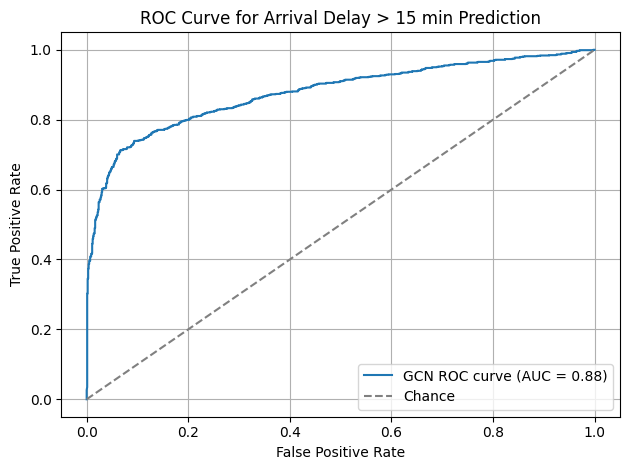

In [ ]:
if isinstance(X, np.ndarray):
    X_tensor = torch.tensor(X, dtype=torch.float)
else:
    X_tensor = X.float()
if isinstance(edge_index, np.ndarray):
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
else:
    edge_index_tensor = edge_index.long()
if isinstance(y, np.ndarray):
    y_tensor = torch.tensor(y, dtype=torch.long)
else:
    y_tensor = y.long()

with torch.no_grad():
    logits = model(X_tensor, edge_index_tensor)          # shape: [num_nodes, 2]
    probs = F.softmax(logits, dim=1).cpu().numpy()      # shape: [num_nodes, 2]

# --- Prepare true and predicted values for test set ---
# test_mask: boolean mask or integer indices
if isinstance(test_mask, (list, np.ndarray)) and test_mask.dtype == bool:
    test_indices = np.where(test_mask)[0]
elif isinstance(test_mask, (list, np.ndarray, torch.Tensor)):
    test_indices = np.array(test_mask)
else:
    test_indices = test_mask

y_true = y_tensor[test_indices].cpu().numpy()           # [num_test_nodes]
y_score = probs[test_indices, 1]                        # prob. of "delayed" class

# --- Binarize labels if needed ---
y_true_bin = label_binarize(y_true, classes=[0, 1]).ravel()

# --- Compute and plot ROC curve ---
fpr, tpr, thresholds = roc_curve(y_true_bin, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"GCN ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Arrival Delay > 15 min Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Not Delayed", "Delayed"]))

              precision    recall  f1-score   support

 Not Delayed       0.71      0.84      0.77       481
     Delayed       0.82      0.69      0.75       519

    accuracy                           0.76      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.76      0.76      1000



In [ ]:
print(f"Average degree: {np.mean([d for n, d in graph.degree()])}")


Average degree: 11.1702


In [ ]:
graph.nodes[10]

{'FlightDate': '2008-03-31',
 'Reporting_Airline': 'MQ',
 'Origin': 'JFK',
 'Dest': 'BOS',
 'CRSDepTime': 2230,
 'DepTime': 2309,
 'Tail_Number': 'N702AE',
 'OriginState': 'NY',
 'Flight_Number_Reporting_Airline': 4609,
 'Distance': 187.0}